<h1> ML PROJECT DEADLINE -2 </h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d meetnagadia/human-action-recognition-har-dataset
! unzip human-action-recognition-har-dataset.zip
! mv Human\ Action\ Recognition Human_Action_Recognition

In [1]:
from PIL import Image
from numpy import random
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from skimage import exposure
from skimage import feature, io
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision import transforms,datasets
from torch.utils.data import Dataset, DataLoader, random_split


import torch.nn.functional as F
import os
import shutil
import pandas as pd
import pickle
import cv2
import numpy as np
import random
import torch
import torchaudio
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt


def path_join(a,b):
    return a+"/"+b

In [ ]:
source_folder="Human_Action_Recognition/train/" # Path to the original training folder containing images
csv_file="Human_Action_Recognition/Training_set.csv" # Path to the CSV file
new_structured_folder="Human_Action_Recognition_organized/"
df=pd.read_csv(csv_file)


# create seperate subfolders for each image class
classes=["sitting","using_laptop","hugging","sleeping","drinking","clapping","dancing","calling","cycling","laughing","fighting","eating","listening_to_music","texting","running"]
classes_to_label={'calling':0, 'clapping':1, 'cycling':2, 'dancing':3, 'drinking':4, 'eating':5, 'fighting':6, 'hugging':7, 'laughing':8, 'listening_to_music':9, 'running':10, 'sitting':11, 'sleeping':12, 'texting':13, 'using_laptop':14}
label_to_classes={0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}

class_to_images={} # maps a class to all the image paths in it
images_to_class={}


for a in classes:
    class_to_images[a]=[]



for idx,row in df.iterrows():
    image_name=row['filename']
    label=row['label']
    curr_image_subfolder=new_structured_folder+label


    src_path=source_folder+image_name
    dest_path=path_join(curr_image_subfolder,image_name)

    class_to_images[label].append(dest_path)
    images_to_class[image_name]=label


img_list=list(images_to_class.keys())

<br><br>
<h3>Computing Histogram of Oriented Features (HOG) to get silhoutte of the image</h3>

In [ ]:
# flag=0 : means image_path
# flag=1 : means image directly (send in grayscale)
def calculate_hog_features(image_path,flag,plot=0):


    if (flag==0):
        image=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    else: image=image_path

    image=cv2.resize(image, (64,128))

    # Calculate HOG features
    fd,hog_feature=hog(image,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(2, 2),block_norm='L2-Hys',visualize=True)
    rescaled_hog_image=exposure.rescale_intensity(hog_feature, in_range=(0, 10))  # Rescale HOG features for better visualization


    if (plot==1):
        plt.figure(figsize=(8, 4))
        plt.subplot(121)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.title('Original Image')
        plt.axis('off')

        # Display the HOG image
        plt.subplot(122)
        plt.imshow(rescaled_hog_image, cmap=plt.cm.gray)
        plt.title('HOG Features')
        plt.axis('off')

        # Show the images
        plt.show()

    return fd

<br><br>
<h3>Edge Detection Filter</h3>

In [ ]:
def apply_sobels_edge(img_path,flag=0,plot=0):

    if (flag==0): img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    else : img=img_path

    blurred1= cv2.GaussianBlur(img, (9, 9), 0)
    blurred2=cv2.bilateralFilter(img, 11,75,200)


    # Apply the Sobel filter for edge detection
    sobels_edges1_x=cv2.Sobel(blurred1,cv2.CV_64F,1,0,ksize=3)  # Sobel filter for detecting horizontal edges
    sobels_edges1_y=cv2.Sobel(blurred1,cv2.CV_64F,0,1,ksize=3)  # Sobel filter for detecting vertical edges
    edges1=np.sqrt(sobels_edges1_x**2+sobels_edges1_y**2)   # Combine the horizontal and vertical edges to obtain the magnitude
    edges1=cv2.normalize(edges1,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U) # Normalize the edge magnitude for better visualization

    sobels_edges2_y=cv2.Sobel(blurred2,cv2.CV_64F,0,1,ksize=3)  # Sobel filter for detecting vertical edges
    sobels_edges2_x=cv2.Sobel(blurred2,cv2.CV_64F,1,0,ksize=3)  # Sobel filter for detecting horizontal edges
    edges2=np.sqrt(sobels_edges2_x**2+sobels_edges2_y**2)   # Combine the horizontal and vertical edges to obtain the magnitude
    edges2=cv2.normalize(edges2,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U) # Normalize the edge magnitude for better visualization


    if (plot==1):
        # Display the original image and the edge map
        fig, axes = plt.subplots(1, 5, figsize=(16, 4))
        plt.subplot(151),
        axes[0].imshow(img, cmap='gray')
        axes[0].axis('off')
        axes[0].set_title('Original Image')

        axes[1].imshow(blurred1, cmap='gray')
        axes[1].axis('off')
        axes[1].set_title('Gaussian Blurred Image')

        axes[2].imshow(edges1, cmap='gray')
        axes[2].axis('off')
        axes[2].set_title('Gaussian Edges')

        axes[3].imshow(blurred2, cmap='gray')
        axes[3].axis('off')
        axes[3].set_title('Bilateral Blurred Image')

        axes[4].imshow(edges2, cmap='gray')
        axes[4].axis('off')
        axes[4].set_title('Bilateral Edges')

    return edges2

<br><br> <h3>Convert To HSV space and calculate colour based histograms</h3>

In [ ]:
# Convert the image to the HSV color space

def calculate_hsv_features(image_path,plot=0):
    img=Image.open(image_path)
    hsv_image=img.convert('HSV')

    # Convert the PIL image to a NumPy array for further processing
    image_array=np.array(hsv_image)

    hist_hue=np.histogram(image_array[:, :, 0], bins=256, range=(0, 256))
    hist_saturation=np.histogram(image_array[:, :, 1], bins=256, range=(0, 256))
    hist_value=np.histogram(image_array[:, :, 2], bins=256, range=(0, 256))

    # Concatenate the histograms
    color_histogram_feature=np.concatenate((hist_hue[0],hist_saturation[0],hist_value[0])).flatten()

    if (plot==1):
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.plot(hist_hue[0])
        plt.title('Hue Histogram')
        plt.subplot(132)
        plt.plot(hist_saturation[0])
        plt.title('Saturation Histogram')
        plt.subplot(133)
        plt.plot(hist_value[0])
        plt.title('Value Histogram')
        plt.show()

    return color_histogram_feature

<br><br><br>
<h3>LBP FEATURES </h3>

In [ ]:
def calculate_lbp_features(old_path,plot=0):
    img=cv2.imread(old_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    lbp_features=feature.local_binary_pattern(gray, P=16, R=2, method='uniform')

    # Calculate histogram
    hist, _ = np.histogram(lbp_features, bins=np.arange(0, 256), range=(0, 255))

    if (plot==1):
        plt.figure(figsize=(10, 5))
        plt.subplot(121), plt.imshow(gray, cmap='gray')
        plt.title('Original Image')
        plt.subplot(122), plt.imshow(lbp_features, cmap='gray')
        plt.title('LBP image')
        plt.show()

    return hist

<br><br><br>
<h3>TRAIN ON WHOLE DATA</h3>

In [ ]:
# RBF kernel(Gaussian)
# C - regularization : high C means less training error(may overfit) and low means better margin
# Gamma - complex decision bdry: high gamma means smooth and capture only points at bdrys (overfit) , large also takes wiggly points

In [ ]:
def feature_extraction(curr_img_path):
    curr_hog_features=calculate_hog_features(curr_img_path,flag=0)
    curr_hsv_features=calculate_hsv_features(curr_img_path)
    curr_lbp_features=calculate_lbp_features(curr_img_path)
    features=np.concatenate((curr_hog_features,curr_hsv_features,curr_lbp_features))
    return features


In [ ]:
# Extract HOG features from the raw image data
X=[]
Y=[]
for a in os.listdir(new_structured_folder):
    curr_class_path=new_structured_folder+a
    for b in os.listdir(curr_class_path):
        curr_img_path=path_join(curr_class_path,b)
        features=feature_extraction(curr_img_path)
        X.append(features)
        Y.append(classes_to_label[a])


X_train=np.array(X)
Y_train=np.array(Y)


scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)

svm_classifier=SVC(kernel='poly',degree=6,C=10,gamma=1)
svm_classifier.fit(X_train, Y_train)


SVC(C=10, degree=6, gamma=1, kernel='poly')

<br><br><br>
<h3>TESTING SCRIPT </h3>

hugging
using_laptop
running
texting
laughing
dancing
eating
running


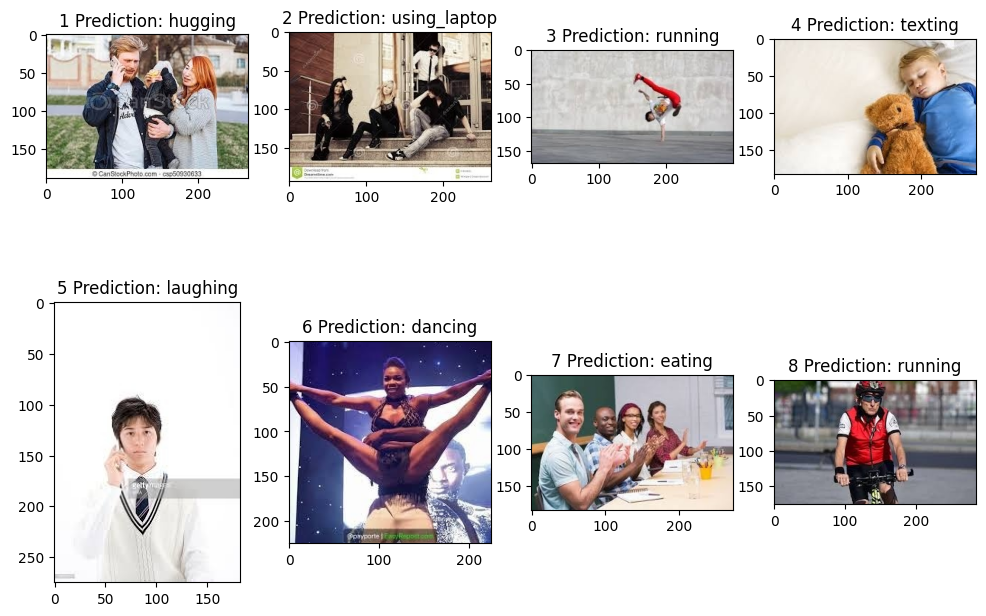

In [ ]:
with open('scaler.pkl', 'rb') as file:
    scaler=pickle.load(file)

with open('svm_model.pkl', 'rb') as file:
    svm_classifier=pickle.load(file)


file_path="Human_Action_Recognition/test/"
paths=[]
random_numbers = random.sample(range(1, 5401), 8)
for a in random_numbers:
    paths.append(file_path+f"Image_{a}.jpg")


fig, axes = plt.subplots(2,4, figsize=(12, 8))
i=0

for path in paths:

    features=feature_extraction(path)
    features_scaled=scaler.transform(features.reshape(1, -1))
    prediction=svm_classifier.predict(features_scaled)

    img=Image.open(path)
    ax = axes[i // 4, i % 4] if 4 > 1 else axes
    ax.imshow(img)
    ax.set_title(f"{i+1} Prediction: {label_to_classes[prediction[0]]}")
    print(label_to_classes[prediction[0]])
    i+=1



<br><br><br><br>
<h3>CREATING CUSTOM CNN ARCHITECTURE</h3>

In [2]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCH = 40
classes_to_label={'calling':0, 'clapping':1, 'cycling':2, 'dancing':3, 'drinking':4, 'eating':5, 'fighting':6, 'hugging':7, 'laughing':8, 'listening_to_music':9, 'running':10, 'sitting':11, 'sleeping':12, 'texting':13, 'using_laptop':14}
label_to_classes={0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}
image_height,image_width=160,160


def load_images(dir):
    images=[]
    labels=[]

    csv_file="./Human_Action_Recognition/Training_set.csv"
    df=pd.read_csv(csv_file)

    for image_file in os.listdir(dir):
        image_path = os.path.join(dir, image_file)

        if image_file=="Image_10169(1).jpg": continue #repeated image

        image_no=int((image_file.split("_")[1]).split(".")[0])
        img = Image.open(image_path)
        img=img.resize((image_height,image_width))
        images.append(np.array(img))
        image_name=image_file
        label=classes_to_label[df.iloc[image_no-1,1]]
        labels.append(label)


    return images,labels


In [3]:
transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_directory = "./Human_Action_Recognition/train/"


train_images, train_labels = load_images(data_directory)
image_train_data, image_temp_data, image_train_labels, image_temp_labels = train_test_split(train_images, train_labels, test_size=0.3, random_state=42)
image_val_data, image_test_data, image_val_labels, image_test_labels = train_test_split(image_temp_data, image_temp_labels, test_size=0.5, random_state=42)

image_datasets_dict={"train":[image_train_data,image_train_labels],"val":[image_val_data,image_val_labels],"test":[image_test_data,image_test_labels]}

<br><h3>CREATING DATASET</h3>

In [4]:
class ImageDataset(Dataset):
    def __init__(self, split:str="train") -> None:
        super().__init__()
        if split not in ["train", "val","test"]:
            raise Exception("Data split must be in [train, test,val]")

        self.datasplit = split
        self.images=image_datasets_dict[split][0]
        self.labels=image_datasets_dict[split][1]
        self.transform=transform_image


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image=self.images[idx]                     #image is already transformed
        if self.transform is not None:
            image = self.transform(image)
        label=self.labels[idx]
        return (image, label)



<br>
<h3>DISPLAYING RANDOM IMAGES</h3>

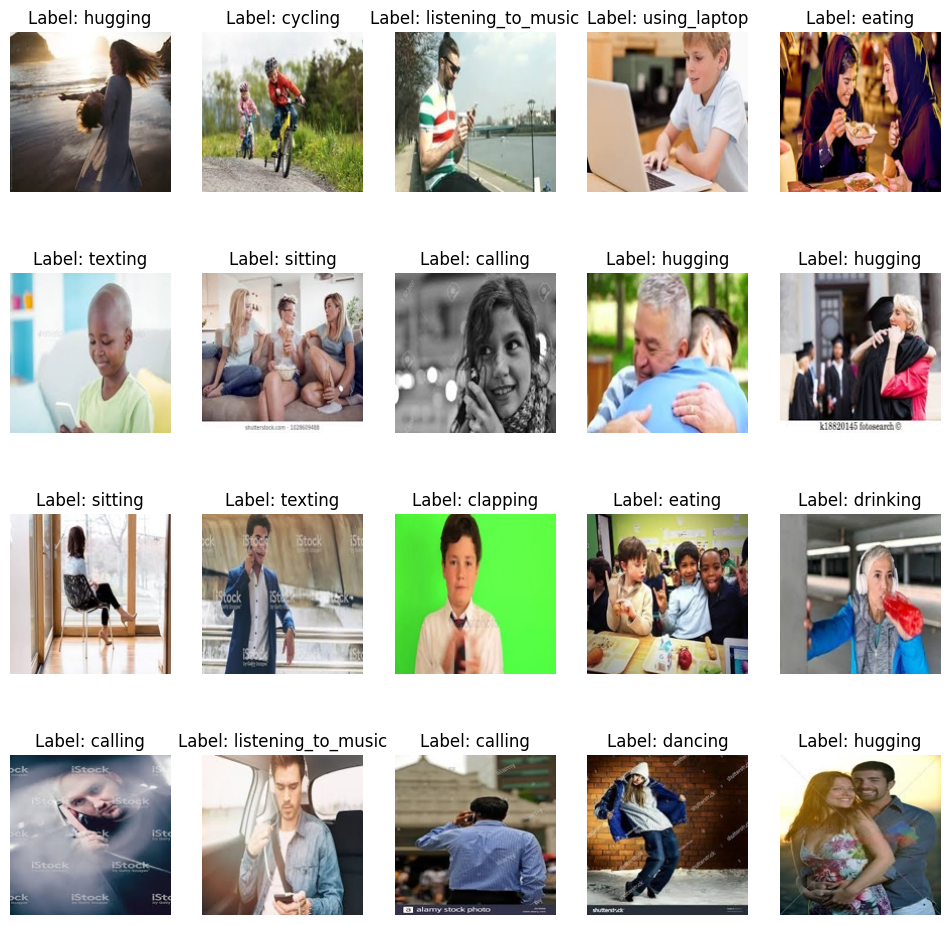

In [7]:
def display_random_images(image_train_data,image_train_labels):
    num_images_to_display = 20
    num_rows = 4
    num_cols = num_images_to_display // num_rows

    random_indices = torch.randperm(len(image_train_data))[:num_images_to_display]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for i in range(num_rows):
        for j in range(num_cols):
            index = random_indices[i * num_cols + j]
            image= image_train_data[index]
            label= image_train_labels[index]
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].set_title(f'Label: {label_to_classes[label]}')
            axes[i, j].axis('off')
    plt.show()




display_random_images(image_train_data,image_train_labels)

<br> <h3>DEFINING MODIFIED INCEPTION ARCHITECTURE</h3>

In [8]:
class InceptionBlock(nn.Module):

    def __init__(self,in_channels,out1_1,out2_1,out2_2,out3_1,out3_2,pool_proj):
        super().__init__()

        # input(3,192,192)

        # add 1x1 conv layers to reduce training time
        # 1X1 CNA
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out1_1, kernel_size=1),
            nn.BatchNorm2d(out1_1),
            nn.ReLU(inplace=True)
        )


        # 3X3 AND 5X5 CNA
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels,out2_1,kernel_size=3,padding=1),
            nn.BatchNorm2d(out2_1),
            nn.ReLU(inplace=True),

            nn.Conv2d(out2_1,out2_2,kernel_size=5,padding=2),
            nn.BatchNorm2d(out2_2),
            nn.ReLU(inplace=True)
        )


        # 3X3 AND 5X5 CNA
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels,out3_1,kernel_size=3,padding=1),
            nn.BatchNorm2d(out3_1),
            nn.ReLU(inplace=True),

            nn.Conv2d(out3_1,out3_2,kernel_size=5,padding=2),
            nn.BatchNorm2d(out3_2),
            nn.ReLU(inplace=True)
        )


        # 3X3 MAXpool
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            nn.Conv2d(in_channels,pool_proj,kernel_size=1),
            nn.ReLU(inplace=True)
        )





    def forward(self,x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1,branch2,branch3,branch4]
        return torch.cat(outputs,1)





class ModifiedInception(nn.Module):
      def __init__(self, num_classes=15) -> None:
        super(ModifiedInception,self).__init__()
        # input(3,192,192)

        self.block1 = InceptionBlock(3,8,4,8,4,8,8)                # output (8+8+8+8=32,192,192)
        self.block2 = InceptionBlock(32,16,8,16,8,16,16)           # output (16+16+16+16=64,96,96)
        self.block3 = InceptionBlock(64,32,16,32,16,32,32)         # output (32+32+32+32=128,48,48)
        self.block4 = InceptionBlock(128,64,32,64,32,64,64)        # output (64+64+64+64=256,24,24)
        self.block5 = InceptionBlock(256,128,64,128,64,128,128)        # output (128+128+128+128=512,12,12)
        self.block6 = InceptionBlock(512,128,64,128,64,128,128)        # output (128+128+128+128=512,6,6)
        self.maxpool = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))                # output (256,1,1)
        self.fc = nn.Linear(512, num_classes)



      def forward(self, x):
          x = self.block1(x)
          x = self.maxpool(x)  # (96,96)
          x = self.block2(x)
          x = self.maxpool(x)  # (48,48)
          x = self.block3(x)
          x = self.maxpool(x)  # (24,24)
          x = self.block4(x)
          x = self.maxpool(x) # (12,12)
          x = self.block5(x)
          x = self.maxpool(x) # (6,6)
          x = self.block6(x)
          # x = self.maxpool(x) # (6,6)
          x= self.avgpool(x)     #(1,1)
          x = x.view(x.size(0), -1)
          x = self.fc(x)
          return x

# source -  https://github.com/Bryant6/DL_Conv_model/blob/master/classification/GoogLeNet.py

In [9]:
def trainer_and_validator(gpu="T",train_dataloader=None,network=None,criterion=None,optimizer=None,val_dataloader=None):

    device = torch.device("cuda:0") if gpu == "T" else torch.device("cpu")
    network = network.to(device)


    # Write your code here
    for epoch in range(EPOCH):
        total_loss, correct, total = 0, 0, 0
        cnt=0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # clear the previous grads because the new ones shouldn't be dependent on them (pytorch inherently stores them)
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # backpropagates the losses
            optimizer.step() # updates all the gradients of previous layers
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) # softmax probs to highest prob class
            total += labels.size(0) # get the no. of samples in a batch
            correct += (predicted == labels).sum().item() # no. of correct

        train_loss = total_loss/len(train_dataloader)
        train_accuracy = correct / total



        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():     # autograd stops gradient computation to yield faster results
            for val_inputs, val_labels in val_dataloader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = network(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_loss = val_loss/len(val_dataloader)
        val_accuracy = val_correct / val_total
        print("Training Epoch: {}, [Loss: {}, Accuracy: {}]      Validation Epoch: {}, [Loss: {}, Accuracy: {}]".format(epoch+1,train_loss,train_accuracy,epoch+1,val_loss,val_accuracy))
    print()





def evaluator(gpu="T",dataloader=None,network=None,criterion=None):

    device = torch.device("cuda:0") if gpu == "T" else torch.device("cpu")
    network = network.to(device)

    test_loss,test_correct,test_total=0,0,0
    with torch.no_grad():
        for test_inputs, test_labels in dataloader:
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)
            test_outputs = network(test_inputs)
            test_loss += criterion(test_outputs, test_labels).item()
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()

    loss = test_loss/len(dataloader)
    accuracy = test_correct / test_total

    print("Testing [Loss: {}, Accuracy: {}]".format(loss,accuracy))



In [10]:
if __name__ == "__main__":

    imageDataset = [
        ImageDataset(split="train"),
        ImageDataset(split="val"),
        ImageDataset(split="test")
    ]


    network=ModifiedInception()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=network.parameters(),lr=LEARNING_RATE)


    for dataset in imageDataset:
        if dataset.datasplit == "train":
            network.train()
            train_dataloader = DataLoader(
                dataset=dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=2,
                drop_last=True
            )



        elif dataset.datasplit == "val":
            print("Training and Validating the Architecture")
            network.train()
            val_dataloader = DataLoader(
                dataset=dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=2,
                drop_last=True
            )


            trainer_and_validator(
                gpu='T',
                train_dataloader=train_dataloader,
                network=network,
                criterion=criterion,
                optimizer=optimizer,
                val_dataloader=val_dataloader
            )




        elif dataset.datasplit == "test":
            print("Testing the Architecture")

            network.eval()
            test_dataloader = DataLoader(
                dataset=dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=2,
                drop_last=True
            )
            evaluator(
                gpu='T',
                dataloader=test_dataloader,
                network=network,
                criterion=criterion)


Training and Validating the Architecture
Training Epoch: 1, [Loss: 2.31428327256983, Accuracy: 0.2334090909090909]      Validation Epoch: 1, [Loss: 2.092244827141196, Accuracy: 0.3003177966101695]
Training Epoch: 2, [Loss: 1.985260108167475, Accuracy: 0.34704545454545455]      Validation Epoch: 2, [Loss: 1.924605458469714, Accuracy: 0.3628177966101695]
Training Epoch: 3, [Loss: 1.7811167283491656, Accuracy: 0.41352272727272726]      Validation Epoch: 3, [Loss: 1.798580499018653, Accuracy: 0.4067796610169492]
Training Epoch: 4, [Loss: 1.6356422888148914, Accuracy: 0.46386363636363637]      Validation Epoch: 4, [Loss: 1.6888936919681097, Accuracy: 0.4576271186440678]
Training Epoch: 5, [Loss: 1.4983364688266407, Accuracy: 0.5135227272727273]      Validation Epoch: 5, [Loss: 1.6298617528656782, Accuracy: 0.4576271186440678]
Training Epoch: 6, [Loss: 1.3822250665317881, Accuracy: 0.5502272727272727]      Validation Epoch: 6, [Loss: 1.5244161557343046, Accuracy: 0.5021186440677966]
Training

<br><h3>TESTING SCRIPT</h3>

using_laptop
running
texting
texting
listening_to_music
listening_to_music
texting
dancing


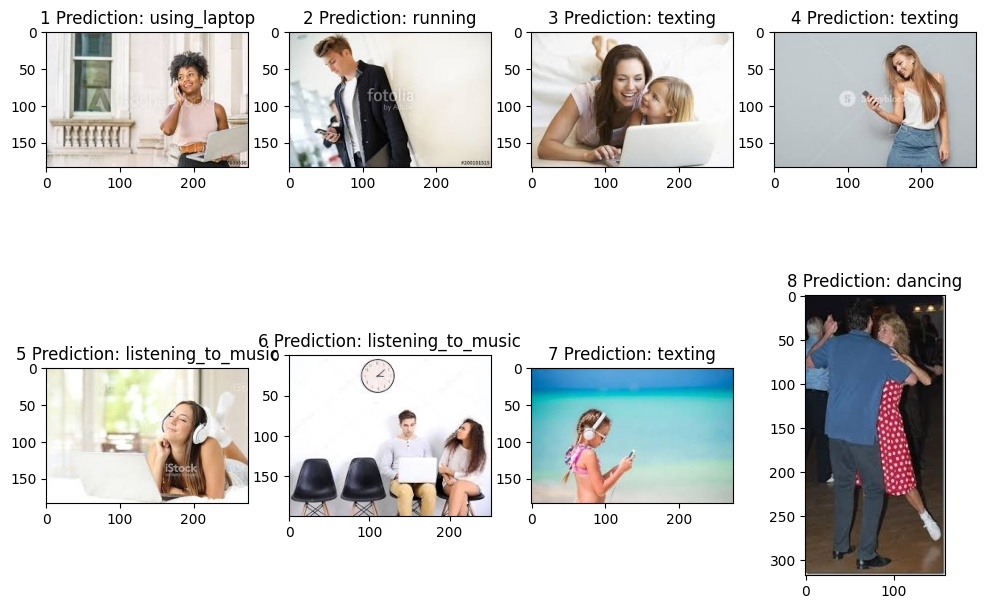

In [11]:
file_path="Human_Action_Recognition/test/"
paths=[]
random_numbers = random.sample(range(1, 5401), 8)
for a in random_numbers:
    paths.append(file_path+f"Image_{a}.jpg")


fig, axes = plt.subplots(2,4, figsize=(12, 8))
i=0

images = []
for path in paths:
    image = Image.open(path)
    image=image.resize((image_height,image_width))
    image = transform_image(image)
    images.append(image)
images = torch.stack(images)  # Stack images along batch dimension


device = torch.device("cuda:0")
with torch.no_grad():
    images = images.to(device)
    outputs = network(images)
    _, predicted = torch.max(outputs, 1)


cnt=0
for path in paths:
    img=Image.open(path)
    ax = axes[i // 4, i % 4] if 4 > 1 else axes
    ax.imshow(img)
    ax.set_title(f"{i+1} Prediction: {label_to_classes[int(predicted[cnt])]}")
    print(label_to_classes[int(predicted[cnt])])
    i+=1
    cnt+=1



<br><br><br><br>
<h3>FINE TUNING PRE-TRAINED MODEL 1 (VGG-16) </h3>

In [6]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm


In [17]:
vgg_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(160,160,3),
                   pooling='avg',classes=15,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

vgg_model.add(pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(15, activation='softmax'))

In [18]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
image_train_data=np.array(image_datasets_dict['train'][0])
image_train_labels=np.array(image_datasets_dict['train'][1])
image_train_labels = tf.keras.utils.to_categorical(image_train_labels, num_classes=15)

In [20]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14985039 (57.16 MB)
Trainable params: 270351 (1.03 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [22]:
history = vgg_model.fit(image_train_data,image_train_labels, epochs=25)

Epoch 1/25
276/276 [==============================] - 96s 349ms/step - loss: 2.0685 - accuracy: 0.4471
Epoch 2/25
276/276 [==============================] - 85s 308ms/step - loss: 1.1920 - accuracy: 0.6179
Epoch 3/25
276/276 [==============================] - 85s 308ms/step - loss: 0.8501 - accuracy: 0.7197
Epoch 4/25
276/276 [==============================] - 85s 308ms/step - loss: 0.6071 - accuracy: 0.8031
Epoch 5/25
276/276 [==============================] - 85s 307ms/step - loss: 0.3889 - accuracy: 0.8782
Epoch 6/25
276/276 [==============================] - 85s 307ms/step - loss: 0.2437 - accuracy: 0.9302
Epoch 7/25
276/276 [==============================] - 85s 307ms/step - loss: 0.1554 - accuracy: 0.9624
Epoch 8/25
276/276 [==============================] - 85s 307ms/step - loss: 0.0911 - accuracy: 0.9808
Epoch 9/25
276/276 [==============================] - 85s 307ms/step - loss: 0.0507 - accuracy: 0.9912
Epoch 10/25
276/276 [==============================] - 85s 307ms/step - l

<br><h3>VALIDATION TESTING</h3>

In [23]:
def validation_testing():
    image_val_data=np.array(image_datasets_dict['val'][0])
    image_val_labels=np.array(image_datasets_dict['val'][1])
    image_val_labels = tf.keras.utils.to_categorical(image_val_labels, num_classes=15)

    result = vgg_model.predict(image_val_data)
    predicted_labels = np.argmax(result, axis=1)

    correct_predictions = np.sum(predicted_labels == image_val_labels.argmax(axis=1))
    total_samples = len(image_val_labels)
    accuracy = correct_predictions / total_samples

    print(f"Validation acc is {accuracy}")



validation_testing()


60/60 [==============================] - 7s 114ms/step
Validation acc is 0.5365079365079365


1/1 [==============================] - 0s 33ms/step
laughing
eating
calling
hugging
calling
running
texting
clapping


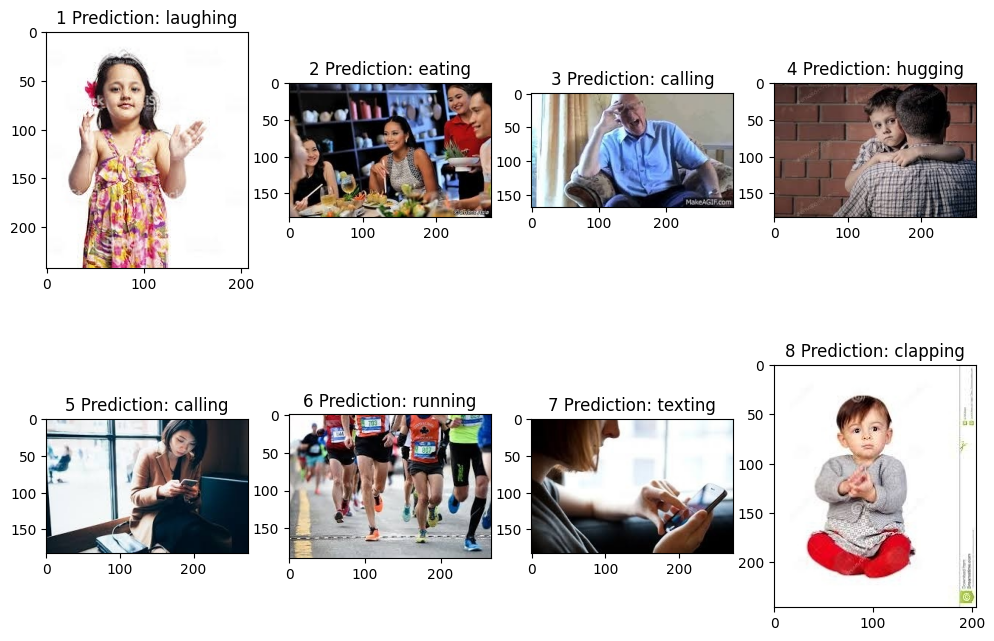

In [25]:
file_path="Human_Action_Recognition/test/"
paths=[]
random_numbers = random.sample(range(1, 5401), 8)
for a in random_numbers:
    paths.append(file_path+f"Image_{a}.jpg")


fig, axes = plt.subplots(2,4, figsize=(12, 8))
i=0

images = []
for path in paths:
    image = Image.open(path)
    image=image.resize((image_height,image_width))
    images.append(np.array(image))
images = np.array(images)

result = vgg_model.predict(images)
predicted_labels = np.argmax(result, axis=1)



cnt=0
for path in paths:
    img=Image.open(path)
    ax = axes[i // 4, i % 4] if 4 > 1 else axes
    ax.imshow(img)
    ax.set_title(f"{i+1} Prediction: {label_to_classes[int(predicted_labels[cnt])]}")
    print(label_to_classes[int(predicted_labels[cnt])])
    i+=1
    cnt+=1

<br><br><br>
<h3>FINE TUNING PRE-TRAINED MODEL 2 (EFFICIENT NET B7) </h3>

In [7]:
efficientnet_model = Sequential()
model = tf.keras.applications.EfficientNetB7(include_top=False,
                                            input_shape=(160,160,3),
                                            pooling ="avg",classes=15,
                                             weights="imagenet")

for layer in model.layers:
    layer.trainable=False


efficientnet_model.add(model)
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(512,activation="relu"))
efficientnet_model.add(Dense(15,activation="softmax"))

In [8]:
image_train_data=np.array(image_datasets_dict['train'][0])
image_train_labels=np.array(image_datasets_dict['train'][1])
image_train_labels = tf.keras.utils.to_categorical(image_train_labels, num_classes=15)

efficientnet_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 65416614 (249.54 MB)
Trainable params: 1318927 (5.03 MB)
Non-trainable params: 64097687 (244.51 MB)
_________________________________________________________________


In [9]:
history2 = efficientnet_model.fit(image_train_data,image_train_labels, epochs=10)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
276/276 [==============================] - 437s 2s/step - loss: 1.3137 - accuracy: 0.5810
Epoch 2/10
276/276 [==============================] - 426s 2s/step - loss: 0.8826 - accuracy: 0.7118
Epoch 3/10
276/276 [==============================] - 424s 2s/step - loss: 0.6507 - accuracy: 0.7948
Epoch 4/10
276/276 [==============================] - 425s 2s/step - loss: 0.4675 - accuracy: 0.8533
Epoch 5/10
276/276 [==============================] - 422s 2s/step - loss: 0.3112 - accuracy: 0.9048
Epoch 6/10
276/276 [==============================] - 421s 2s/step - loss: 0.2155 - accuracy: 0.9374
Epoch 7/10
276/276 [==============================] - 425s 2s/step - loss: 0.1586 - accuracy: 0.9561
Epoch 8/10
276/276 [==============================] - 431s 2s/step - loss: 0.1152 - accuracy: 0.9694
Epoch 9/10
276/276 [==============================] - 434s 2s/step - loss: 0.1039 - accuracy: 0.9718
Epoch 10/10
276/276 [==============================] - 436s 2s/step - loss: 0.0868 - accura

<br><h3>VALIDATION TESTING</h3>

In [10]:

def validation_testing():
    image_val_data=np.array(image_datasets_dict['val'][0])
    image_val_labels=np.array(image_datasets_dict['val'][1])
    image_val_labels = tf.keras.utils.to_categorical(image_val_labels, num_classes=15)

    result = efficientnet_model.predict(image_val_data)
    predicted_labels = np.argmax(result, axis=1)

    correct_predictions = np.sum(predicted_labels == image_val_labels.argmax(axis=1))
    total_samples = len(image_val_labels)
    accuracy = correct_predictions / total_samples

    print(f"Validation acc is {accuracy}")



validation_testing()


60/60 [==============================] - 36s 594ms/step
Validation acc is 0.6624338624338625


1/1 [==============================] - 1s 541ms/step
using_laptop
listening_to_music
using_laptop
sleeping
running
hugging
hugging
listening_to_music


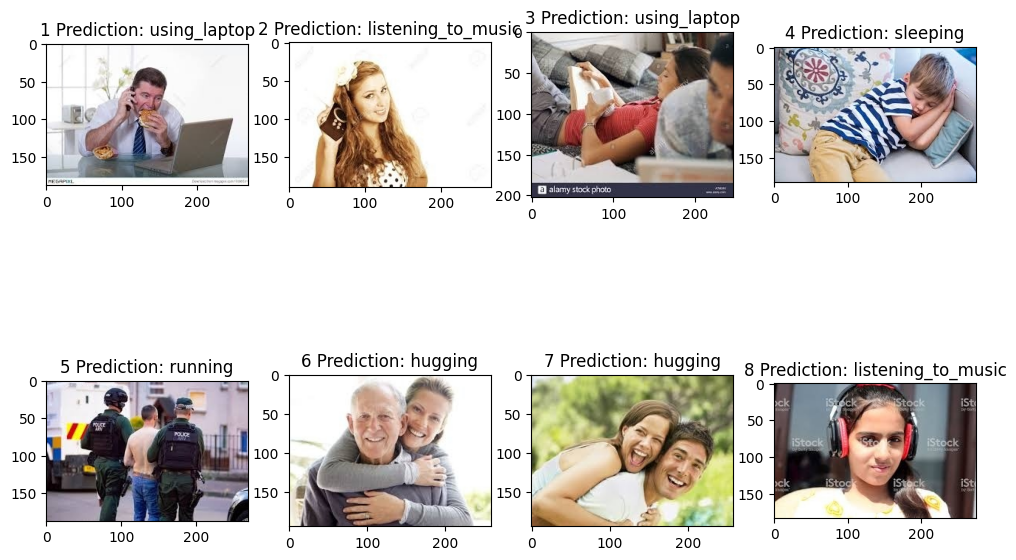

In [16]:
file_path="Human_Action_Recognition/test/"
paths=[]
random_numbers = random.sample(range(1, 5401), 8)
for a in random_numbers:
    paths.append(file_path+f"Image_{a}.jpg")




fig, axes = plt.subplots(2,4, figsize=(12, 8))
i=0

images = []
for path in paths:
    image = Image.open(path)
    image=image.resize((image_height,image_width))
    images.append(np.array(image))
images = np.array(images)

result = efficientnet_model.predict(images)
predicted_labels = np.argmax(result, axis=1)


cnt=0
for path in paths:
    img=Image.open(path)
    ax = axes[i // 4, i % 4] if 4 > 1 else axes
    ax.imshow(img)
    ax.set_title(f"{i+1} Prediction: {label_to_classes[int(predicted_labels[cnt])]}")
    print(label_to_classes[int(predicted_labels[cnt])])
    i+=1
    cnt+=1

<br><br><hr>